<a href="https://colab.research.google.com/github/kk0mtl/computer-vision/blob/main/cifar10_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [112]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

# Hyper params
batch_size = 64
learning_rate = 0.008
num_epoch = 20

In [93]:
#Data Augmentation (32*32)
cifar_train = dset.CIFAR10("/content/drive/MyDrive/cifar10_task", train=True,
                           transform=transforms.Compose([
                               transforms.RandomCrop(32, padding=4),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                                                    (0.24703223, 0.24348513, 0.26158784))
                           ]), target_transform=None, download=True)

data = np.array(cifar_train.data)
mean = data.mean(axis=(0, 1, 2)) / 255
std = data.std(axis=(0, 1, 2)) / 255

print("shape:", data.shape)
print("mean:", mean)
print("std:", std)

cifar_test = dset.CIFAR10("/content/drive/MyDrive/cifar10_task", train=False,
                          transform=transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.49421428, 0.48513139, 0.45040909),
                               (0.24665252, 0.24289226, 0.26159238))
                          ]),
                          target_transform=None, download=True)

data = np.array(cifar_test.data)
mean = data.mean(axis=(0, 1, 2)) / 255
std = data.std(axis=(0, 1, 2)) / 255

print("shape:", data.shape)
print("mean:", mean)
print("std:", std)

Files already downloaded and verified
shape: (50000, 32, 32, 3)
mean: [0.49139968 0.48215841 0.44653091]
std: [0.24703223 0.24348513 0.26158784]
Files already downloaded and verified
shape: (10000, 32, 32, 3)
mean: [0.49421428 0.48513139 0.45040909]
std: [0.24665252 0.24289226 0.26159238]


In [94]:
units = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cifar_train 길이 :  50000
cifar_test 길이 :  10000
image data 형태 :  torch.Size([3, 32, 32])
label :  9


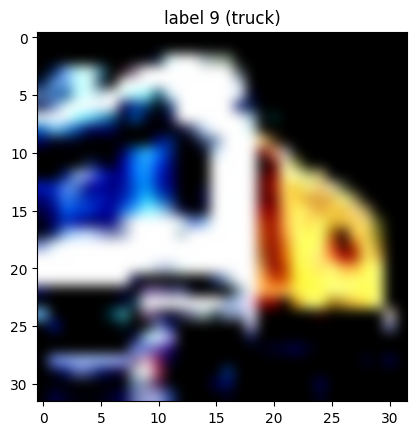

In [95]:
print("cifar_train 길이 : ", len(cifar_train))
print("cifar_test 길이 : ", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("image data 형태 : ", image.size())
print("label : ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label %d (%s)" % (label, units[label]))
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [106]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(list(cifar_test)[:], batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

class CNN(nn.Module):
  def __init__(self):
      super(CNN,self).__init__()
      self.layer = nn.Sequential(
          nn.Conv2d(3, 16, 3, padding=1),
          nn.ReLU(),
          # nn.Dropout2d(0.5),
          nn.BatchNorm2d(16), # output : 16*32*32
          nn.Conv2d(16, 32, 3, padding=1),
          nn.ReLU(),
          # nn.Dropout2d(0.5),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(2,2),  # output : 32*16*16
          nn.Conv2d(32,64,3,padding=1),
          nn.ReLU(),
          # nn.Dropout2d(0.5),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2,2)   # output : 64*8*8
      )

      self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 256),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.BatchNorm1d(256),

        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.BatchNorm1d(64),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.BatchNorm1d(32),

        nn.Linear(32,10)
      )

      #weight init
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          init.kaiming_normal(m.weight.data)
          m.bias.data.fill_(0)
        if isinstance(m, nn.Linear):
          init.kaiming_normal(m.weight.data)
          m.bias.data.fill_(0)

  def forward(self, x):
      out = self.layer(x)
      out = out.view(out.size(0), -1) # flatten
      out = self.fc_layer(out)

      return out

# model = CNN()
model = CNN().cuda()

<ipython-input-106-d6b33bf76183>:46: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-106-d6b33bf76183>:49: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


In [97]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  imodel.eval()
  with torch.no_grad():
    for j, [imgs, labels] in enumerate(dloader):
      # img = Variable(imgs, volatile=True)
      img = Variable(imgs, volatile=True).cuda()
      # label = Variable(labels)
      label = Variable(labels).cuda()

      output = imodel.forward(img)
      _, output_index = torch.max(output, 1)

      total += label.size(0)
      correct += (output_index == label).sum().float()
    print("Accuracy of Test Data : {}".format(100*correct/total))

In [113]:
# loss_func = nn.CrossEntropyLoss().cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [114]:
model.train()
# 학습
for i in range(num_epoch):
  running_loss = 0.0
  for j, [image, label] in enumerate(train_loader):
    # x=Variable(image)
    x=Variable(image).cuda()
    # y_=Variable(label)
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output, y_)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # epoch 끝날때마다 avg loss 출력
  epoch_loss = running_loss / len(train_loader)
  print(f"Epoch [{i + 1}/{num_epoch}], Average Loss: {epoch_loss:.4f}")

Epoch [1/20], Average Loss: 1.0150
Epoch [2/20], Average Loss: 0.9443
Epoch [3/20], Average Loss: 0.9085
Epoch [4/20], Average Loss: 0.9013
Epoch [5/20], Average Loss: 0.8880
Epoch [6/20], Average Loss: 0.8751
Epoch [7/20], Average Loss: 0.8628
Epoch [8/20], Average Loss: 0.9463
Epoch [9/20], Average Loss: 0.8437
Epoch [10/20], Average Loss: 0.8288
Epoch [11/20], Average Loss: 0.8643
Epoch [12/20], Average Loss: 0.7989
Epoch [13/20], Average Loss: 0.7904
Epoch [14/20], Average Loss: 0.7923
Epoch [15/20], Average Loss: 0.7754
Epoch [16/20], Average Loss: 0.7628
Epoch [17/20], Average Loss: 0.7628
Epoch [18/20], Average Loss: 0.7404
Epoch [19/20], Average Loss: 0.7285
Epoch [20/20], Average Loss: 0.7250


In [115]:
# model.eval()  # ComputeAccr 함수 내에 추가함
ComputeAccr(test_loader, model)

<ipython-input-97-b08632d4c081>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs, volatile=True).cuda()


Accuracy of Test Data : 71.62460327148438


In [116]:
# 파라미터 저장
netname = '/content/drive/MyDrive/cifar10_task/nets/result.pkl'
torch.save(model, netname,)

In [117]:
# 저장된 파라미터 로드 & 성능 측정
netname = '/content/drive/MyDrive/cifar10_task/nets/result.pkl'
model1 = torch.load(netname)

# model.eval()
ComputeAccr(test_loader, model1)

<ipython-input-97-b08632d4c081>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs, volatile=True).cuda()


Accuracy of Test Data : 71.62460327148438
